# Clean notebook to evaluate upgraded MemNet

New model based on DenseNet. This notebook gives the necessary functions to load data and evaluate a given ckpt.

In [1]:
# Imports
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, GlobalAveragePooling2D, Input, TimeDistributed
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence
import os
import cv2
from cv2 import imread, resize
from scipy.stats import spearmanr
import keras.backend as K
from keras.optimizers import Adam, SGD
import seaborn as sns
import pandas as pd
import sys
from PIL import Image


%load_ext autoreload
%autoreload 2

## Instantiate DenseNet

In [2]:
# Instantiating a DenseNet121 
from keras.applications.densenet import DenseNet121

densenet = DenseNet121(weights='imagenet', include_top=False)

inp = Input(shape=(224,224,3))
x = densenet(inp)
x = GlobalAveragePooling2D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs = inp, outputs = x)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


## Getting train and test data

In [3]:
def get_filenames_labels(txt_file, data_path):
    '''Gets array of image filenames and labels for a given txt_file correpsonding to a lamem split.
    Inputs:
        txt_file: string with the name of the txt_file. Expected to be found in the splits folder of lamem.
        data_path: relative or absolute path to the lamem folder. The folder has to contain a "splits" and an "images" folder.
    Returns:
        two numpy arrays of the same size. The first contains filenames (strings), the second contains memorability scores (float).
    '''
    
    with open(os.path.join(data_path, 'splits', txt_file), 'r') as file:
        lines =  [l.split(' ') for l in file]
        image_filepaths = [os.path.join(data_path, 'images', l[0]) for l in lines]
        labels =  [float(l[1][:-2]) for l in lines]
    return np.array(image_filepaths), np.array(labels)

In [4]:
files_train = {}
files_val = {}
files_test = {}
y_train = {}
y_val = {}
y_test = {}

# input the path to the main lamem folder (should contain a 'splits' folder and an 'images' folders)
data_path = '../../lamem/lamem'

splits_to_load = [1,2,3,4,5]

for s in splits_to_load:

    files_train[s], y_train[s] = get_filenames_labels('train_%s.txt'%s, data_path)
    files_val[s], y_val[s] = get_filenames_labels('val_%s.txt'%s, data_path)
    files_test[s], y_test[s] = get_filenames_labels('test_%s.txt'%s, data_path)

print('shapes of train, test and val arrays for split 1:',files_train[1].shape, y_train[1].shape, files_val[1].shape, y_val[1].shape, files_test[1].shape, y_test[1].shape)

shapes of train, test and val arrays for split 1: (45000,) (45000,) (3741,) (3741,) (10000,) (10000,)


## Evaluate Model
Evaluate MSE on full val and test + Rank correlaction on full val and test

In [5]:
# load up a model or use the one that we just trained above
LOAD_MODEL = True

if LOAD_MODEL:
    model_eval=model
    model_eval.load_weights('weights-rc0.662.hdf5')
else:
    model_eval = model
    
model_eval.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Model)          multiple                  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________


### Set up Keras Generator

In [6]:

class MemGenerator(Sequence):

    def __init__(self, image_filenames, labels, batch_size, img_size=(224,224), shuffle=True, augment=False, mixup=False, two_losses=False):
        self.image_filenames, self.labels = np.array(image_filenames), np.array(labels)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.mixup=mixup
        self.two_losses=two_losses

        if augment:
            sometimes = lambda aug: iaa.Sometimes(0.4, aug)

            self.seq = iaa.Sequential([
                    sometimes(iaa.CropAndPad(px=(0, 20))), # crop images from each side by 0 to 16px (randomly chosen)
                    iaa.Fliplr(0.5), # horizontally flip 50% of the images
                    sometimes(iaa.CoarseDropout(p=0.1, size_percent=0.05)),
                    sometimes(iaa.Affine(rotate=(-15, 15)))
                ])


        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        images=[]
        for file_name in batch_x:
#             print(file_name)
            im = imread(file_name)[...,::-1]
#             im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


            images.append(im)

        if self.augment:
            images = self.seq.augment_images(images)


        img_batch = np.array([resize(im/255.0, self.img_size) for im in images])

        if self.augment and self.mixup:
            if np.random.rand()>0.85:
                alpha = np.random.rand()
                blended = img_batch[0]*(1.0-alpha) + img_batch[1]*alpha
                blended_y = batch_y[0]*(1.0-alpha) + batch_y[1]*alpha

#                 print('blending images with alpha %.4f!!!' % alpha)
#                 print('min max of blended', blended.min(), blended.max(), type(blended[0,0,0]))

                img_batch[0] = blended
                batch_y[0] = blended_y

        if self.two_losses:
            return img_batch, [np.array(batch_y),np.array(batch_y)]
        else:
            return img_batch, np.array(batch_y)


    def on_epoch_end(self):
        if self.shuffle:
            idxs = list(range(len(self.image_filenames)))
            np.random.shuffle(idxs)
            self.image_filenames = self.image_filenames[idxs]
            self.labels = self.labels[idxs]




### Generate predictions

In [7]:
%%time
eval_train=False

splits_to_test = [1,2,3,4]

y_pred_train={}
y_pred_val={}
y_pred_test={}

for s in splits_to_test:

    if eval_train:
        train_gen = MemGenerator(files_train[s], y_train[s], batch_size=30,shuffle=False)
    val_gen = MemGenerator(files_val[s], y_val[s], batch_size=30, shuffle=False)
    test_gen = MemGenerator(files_test[s], y_test[s], batch_size=30, shuffle=False) 

    if eval_train:
        y_pred_train[s] = model_eval.predict_generator(train_gen, workers=10)
    y_pred_val[s] = model_eval.predict_generator(val_gen, workers=10, verbose=True)
    y_pred_test[s] = model_eval.predict_generator(test_gen, workers=10, verbose=True)


Instructions for updating:
Please use Model.predict, which supports generators.
334/334 [==============================] - 69s 206ms/step
CPU times: user 6min 37s, sys: 1min 47s, total: 8min 25s
Wall time: 2min 14s


### Plot the distributions of memorability predictions vs ground truth predictions for each split

SPLIT 1


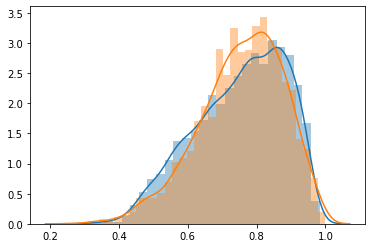

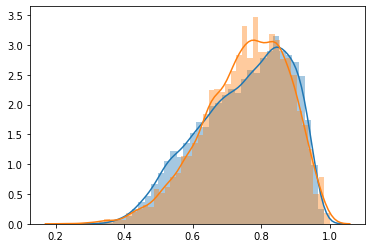

In [19]:
# Distribution of preds vs ground truth

for s in splits_to_test:
    print('SPLIT',s)
    
    if eval_train:
        plt.figure()
        sns.distplot(y_pred_train[s])
        sns.distplot(y_train[s])
    
    plt.figure()
    sns.distplot(y_pred_val[s])
    sns.distplot(y_val[s])
    
    plt.figure()
    sns.distplot(y_pred_test[s])
    sns.distplot(y_test[s])
    
    plt.show()

### Compute MSE and RC for each split

In [20]:
mse_val_sum=0
mse_test_sum=0
mse_train_sum=0
r_val_sum=0
r_test_sum=0
r_train_sum=0

for s in splits_to_test:
     
    if eval_train:
        mse_train = np.mean((y_train[s] - y_pred_train[s])**2)
        r_train = spearmanr(y_train[s],y_pred_train[s])[0]
        mse_train_sum += mse_train
        r_train_sum +=r_train

    mse_val = np.mean((y_val[s] - y_pred_val[s])**2)
    mse_test = np.mean((y_test[s] - y_pred_test[s])**2)

    r_val = spearmanr(y_val[s],y_pred_val[s])[0]
    r_test = spearmanr(y_test[s],y_pred_test[s])[0]

    print('split:',s)
    if eval_train:
        print('TRAIN: MSE %.4f,  RANK CORR %.4f'%( mse_train, r_train))
    print('VAL: MSE %.4f,  RANK CORR %.4f' % (mse_val, r_val))
    print('TEST: MSE %.4f,  RANK CORR %.4f' % (mse_test, r_test))
    
    mse_val_sum += mse_val     
    mse_test_sum += mse_test
    
    r_val_sum += r_val
    r_test_sum += r_test
    
    
print('\n Average over splits:')
if eval_train:
    print('TRAIN: AVG MSE %.4f, AVG RANK CORR %.4f:' % (mse_train_sum/len(splits_to_test), r_train_sum/len(splits_to_test)))
print('VAL: AVG MSE %.4f, AVG RANK CORR %.4f' % (mse_val_sum/len(splits_to_test), r_val_sum/len(splits_to_test)))
print('TEST: AVG MSE %.4f, AVG RANK CORR %.4f' % (mse_test_sum/len(splits_to_test), r_test_sum/len(splits_to_test)))


split: 1
VAL: MSE 0.0322,  RANK CORR 0.6540
TEST: MSE 0.0327,  RANK CORR 0.6620

 Average over splits:
VAL: AVG MSE 0.032, AVG RANK CORR 0.654
TEST: AVG MSE 0.033, AVG RANK CORR 0.662


*Note:* The 'weights-rc0.662.hdf5' checkpoint contains a MemNet trained on split 1, hence the difference in performance between splits. The test sets of splits 2,3,4 contain data that the net has seen during training, so the RC results are not representative (higher than they should) for those splits.